In [1]:
from main import main
from PDconfig import MeLi
from archivosDF import *

main()
ruta_barrios = './DataFrames/MeLi/barrios.csv'
ruta_ciudades = './DataFrames/MeLi/ciudades.csv'
df = abrirDF(MeLi)
df.value_counts("tipoPropiedad")

In [160]:
import numpy as np
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df = df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado', 'cantDormitorios', 'cantBanos', 'cantCochera'])
filt = df['barrio'].str.contains('INMUEBLES', na=False)
df.loc[filt, 'barrio'] = np.nan

filt = (df['ciudad'] == 'CALAMUCHITA') | (df['ciudad'] == 'COLON') | (df['ciudad'] == 'SANTA MARIA')| (df['ciudad'] == 'PUNILLA')| (df['ciudad'] == 'SAN ALBERTO')
df.loc[filt, 'ciudad'] = df.loc[filt, 'barrio']
filt = (df['ciudad'] == df['barrio'])
df.loc[filt, 'barrio'] = np.nan

# ELIMINAR TIPO PROP INSERVIBLES
filt = (df["tipoPropiedad"] == "CASA") | (df["tipoPropiedad"] == "DEPARTAMENTO") | (df["tipoPropiedad"] == "TERRENO")
df = df.loc[filt]

# SEPARAR TERRENOS/LOTES DEL RESTO
terrenos = df.loc[df["tipoPropiedad"] == "TERRENO"]
inmuebles = df.loc[df["tipoPropiedad"] != "TERRENO"]

In [161]:
# FILTRADO DETALLADO INMUEBLES
filtro_TT = inmuebles["terrenoTotal"].between(inmuebles["terrenoTotal"].quantile(0.001), 
                                          inmuebles["terrenoTotal"].quantile(0.99))
filtro_P = inmuebles["precioUSD"].between(inmuebles["precioUSD"].quantile(0.001), 
                                          inmuebles["precioUSD"].quantile(0.99))
inmuebles_filt = inmuebles.loc[filtro_TT & filtro_P]

# Convert the 'fechaUltimaActualizacion' column to datetime objects
inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], format='%d-%m-%Y')
# Filter the DataFrame to include only rows from the year 2023
inmuebles_filt = inmuebles_filt.loc[inmuebles_filt['fechaUltimaActualizacion'].dt.year == 2023]

C:\Users\benja\AppData\Local\Temp\ipykernel_7532\1421760966.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], format='%d-%m-%Y')


In [162]:
# Agrupar barrios
g_barrios = inmuebles_filt.groupby(['barrio', 'ciudad'])

# Calculamos Precio Promedio por barrio
costo_prom_barrio = g_barrios['precioUSD'].mean().round(0)
costo_med_barrio = g_barrios['precioUSD'].median().round(0)

# Step 3: Calculate the cost per square meter ($/m2) for each group (including houses with barrio)
inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

costo_prom_m2_tot_barrio = g_barrios['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_barrio = g_barrios['precio_m2_edif'].mean().round(0)

costo_med_m2_tot_barrio = g_barrios['precio_m2_total'].median().round(0)
costo_med_m2_edif_barrio = g_barrios['precio_m2_edif'].median().round(0)

# Step 4: Count the number of houses being sold in each group (including houses with barrio)
inmuebles_por_barrio = g_barrios.size()

# Add the results for barrio-level statistics to the city results
resultados_barrio = pd.DataFrame({
    'Costo Prom': costo_prom_barrio,
    'Costo Med': costo_med_barrio,
    'Prom $/m2 Total': costo_prom_m2_tot_barrio,
    'Med $/m2 Total': costo_med_m2_tot_barrio,
    'Prom $/m2 Edif': costo_prom_m2_edif_barrio,
    'Med $/m2 Edif': costo_med_m2_edif_barrio,
    'Cant': inmuebles_por_barrio
}).reset_index()

51


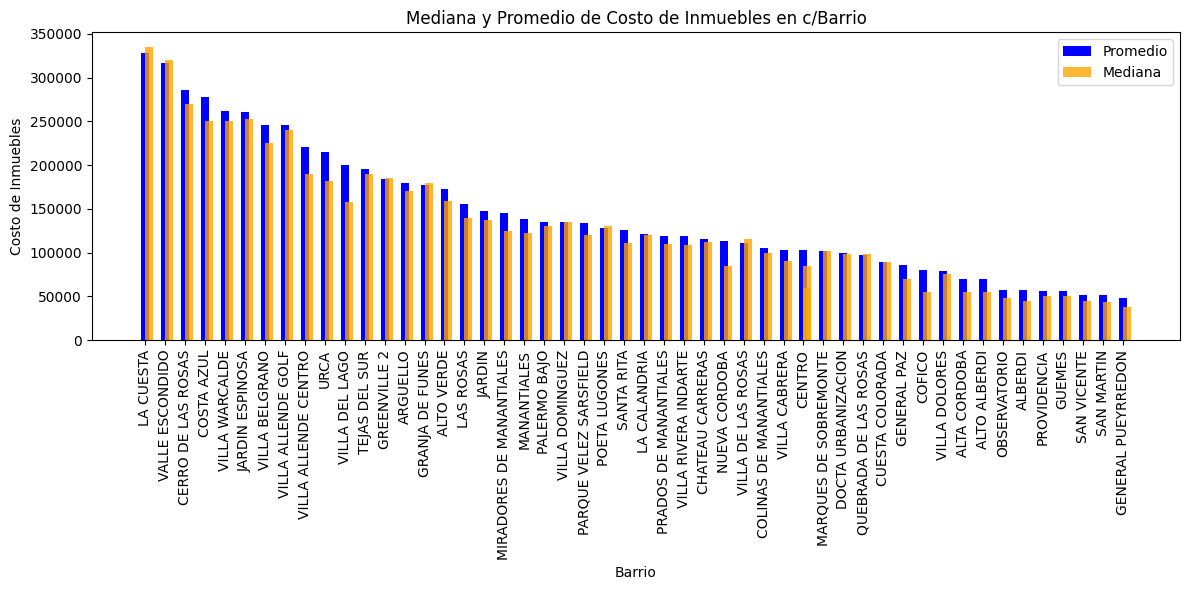

In [163]:
import matplotlib.pyplot as plt

resultados_barrio_sorted = resultados_barrio.sort_values(by='Costo Prom', ascending=False)
resultados_barrio_sorted = resultados_barrio_sorted.loc[resultados_barrio_sorted['Cant'] > 30]

plt.figure(figsize=(12, 6))
barrio_names = resultados_barrio_sorted['barrio']
print(len(barrio_names))
bar_width = 0.4

plt.bar(barrio_names, resultados_barrio_sorted['Costo Prom'], width=bar_width, label='Promedio', color='blue')

plt.bar(barrio_names, resultados_barrio_sorted['Costo Med'], width=bar_width, label='Mediana', color='orange', alpha=0.8, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Costo de Inmuebles')
plt.title('Mediana y Promedio de Costo de Inmuebles en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [164]:
import pandas as pd

# Step 2: Calculate the price per squared meter ($/m²) for each group
inmuebles_filt['precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt['precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

# Step 1: Group the data by 'ciudad', 'barrio', and 'tipoPropiedad'
grouped_data = inmuebles_filt.groupby(['ciudad', 'barrio', 'tipoPropiedad'])

# Step 3: Calculate the mean price per squared meter for each group
precio_m2_total_mean = grouped_data['precio_m2_total'].mean()
precio_m2_total_median = grouped_data['precio_m2_total'].median()
precio_m2_edif_mean = grouped_data['precio_m2_edif'].mean()
precio_m2_edif_median = grouped_data['precio_m2_edif'].median()

# Step 4: Calculate the count of properties in each group
group_counts = grouped_data.size()

# Reset index to convert the grouped results to DataFrames
precio_m2_total_mean_df = precio_m2_total_mean.reset_index()
precio_m2_edif_mean_df = precio_m2_edif_mean.reset_index()
precio_m2_total_median_df = precio_m2_total_median.reset_index()
precio_m2_edif_median_df = precio_m2_edif_median.reset_index()

# Rename columns for clarity
precio_m2_total_mean_df.rename(columns={'precio_m2_total': 'Precio m2 Total Mean'}, inplace=True)
precio_m2_edif_mean_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Mean'}, inplace=True)
precio_m2_total_median_df.rename(columns={'precio_m2_total': 'Precio m2 Total Median'}, inplace=True)
precio_m2_edif_median_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Median'}, inplace=True)

# Step 5: Add the count column to each DataFrame
precio_m2_edif_median_df['Count'] = group_counts.values

# Step 6: Merge the results into a single DataFrame
merged_df = pd.merge(precio_m2_total_mean_df, precio_m2_edif_mean_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_total_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_edif_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])


19


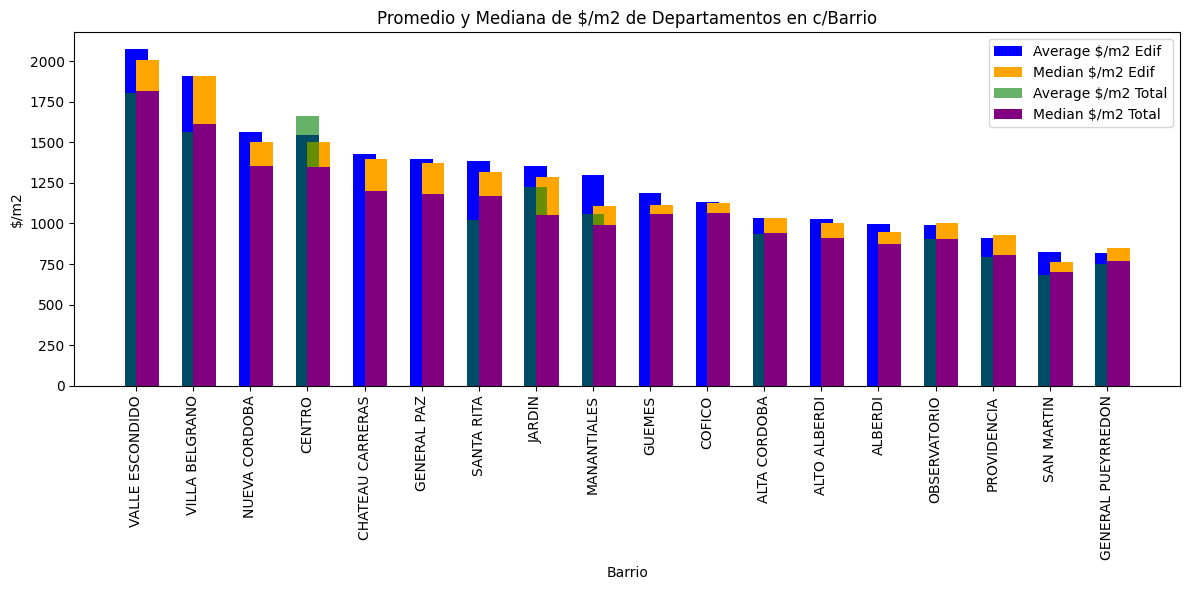

In [165]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
departamento_df = merged_df.sort_values("Precio m2 Edif Mean", ascending=False)
departamento_df = departamento_df[(departamento_df['tipoPropiedad'] == 'DEPARTAMENTO') & (departamento_df["Count"] > 30)]
plt.figure(figsize=(12, 6))
barrio_names = departamento_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2 Edif', color='orange', align='edge')

# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Total Mean'], width=bar_width, label='Average $/m2 Total', color='green', alpha = 0.6)

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Total Median'], width=bar_width, label='Median $/m2 Total', color='purple', align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


33


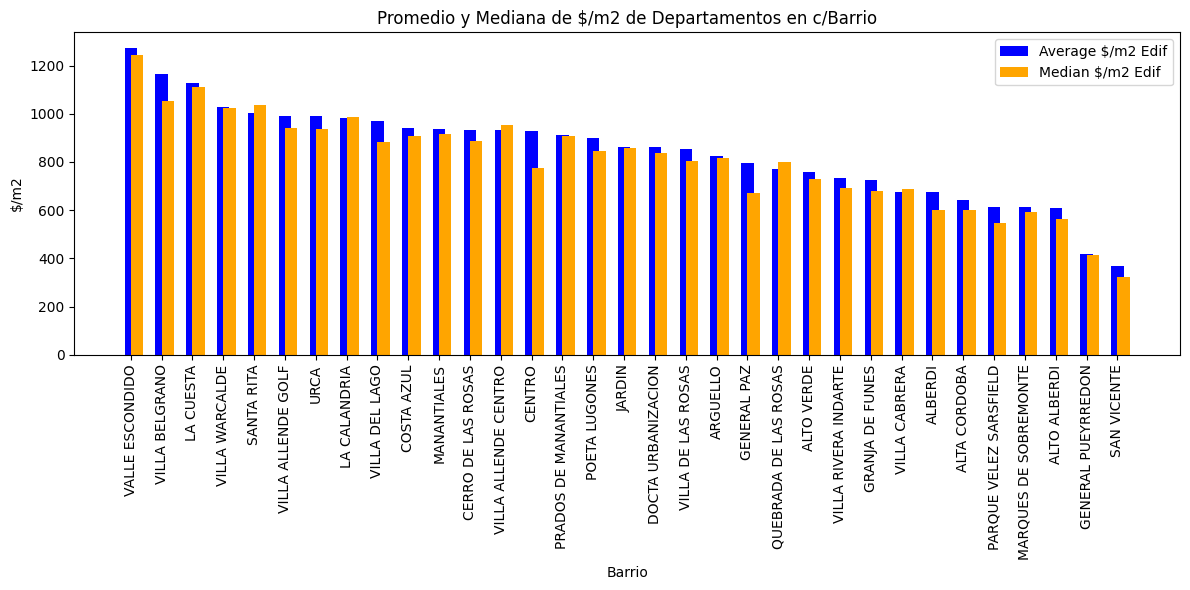

In [166]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
departamento_df = merged_df.sort_values("Precio m2 Edif Mean", ascending=False)
departamento_df = departamento_df[(departamento_df['tipoPropiedad'] == 'CASA') & (departamento_df["Count"] > 30)]
plt.figure(figsize=(12, 6))
barrio_names = departamento_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2 Edif', color='orange', align='edge')

"""# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Total Mean'], width=bar_width, label='Average $/m2 Total', color='red', alpha = 0.4)

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Total Median'], width=bar_width, label='Median $/m2 Total', color='purple', align='edge', alpha = 0.4)"""

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()
